In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import v2
from torchvision.utils import make_grid
from skimage import io
from skimage.feature import local_binary_pattern 
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
import matplotlib.image as mpimg
import cv2
from PIL import Image


In [2]:
image1 = cv2.imread('E:/Datasets/Chest CT-Scan images Dataset/Data/test/cancer/0.png')

In [3]:
image_gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
lbp_c = local_binary_pattern(image_gray1, 16,8, 'uniform')

In [4]:
image1.shape

(282, 381, 3)

In [5]:
image_gray1.shape

(282, 381)

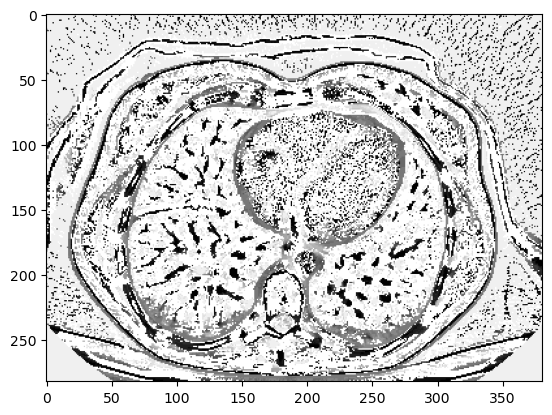

In [6]:
plt.imshow(lbp_c,cmap='gray')
plt.show()

In [7]:
lbp_c.shape

(282, 381)

In [8]:
type(lbp_c)

numpy.ndarray

In [9]:
type(image1)

numpy.ndarray

In [10]:
plt.imshow(image1)

In [11]:
image1[:, :, 0]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
#image_gray2 = cv2.cvtColor(lbp, cv2.COLOR_BGR2GRAY)
lbp0 = local_binary_pattern(image1[:,:,0], 32, 8, 'uniform')
lbp1 = local_binary_pattern(image1[:,:,1], 32, 8, 'uniform')
lbp2 = local_binary_pattern(image1[:,:,2], 32, 8, 'uniform')

In [13]:
image1[:,:,0] = lbp0
image1[:,:,1] = lbp1
image1[:,:,2] = lbp2

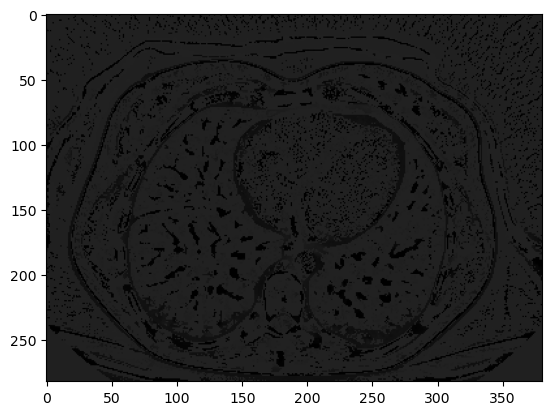

In [14]:
plt.imshow(image1)
plt.show()

In [15]:
class CTScanDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # If using PIL for 2D images, or you can use other libraries for 3D scans
        image = Image.open(img_path)  
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [16]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to (256x256) if needed
    transforms.ToTensor(),          # Convert to PyTorch tensor
    #transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize (CT images might be grayscale)
])


In [17]:
train_dir = 'E:/Datasets/Chest CT-Scan images Dataset/Data/train'
test_dir = 'E:/Datasets/Chest CT-Scan images Dataset/Data/test'

In [18]:
train_dataset = datasets.ImageFolder(root = train_dir, transform = transform)
test_dataset  = datasets.ImageFolder(root = test_dir, transform = transform)

In [19]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = True, num_workers = 4)

In [20]:
print(train_dataset.class_to_idx)

{'cancer': 0, 'normal': 1}


In [21]:
for images,labels in train_loader:
    print(images.shape)
    print(labels)
    break

torch.Size([16, 3, 128, 128])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])


In [22]:
images.shape

torch.Size([16, 3, 128, 128])

In [23]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 624
    Root location: E:/Datasets/Chest CT-Scan images Dataset/Data/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [24]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 315
    Root location: E:/Datasets/Chest CT-Scan images Dataset/Data/test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [25]:
class_names = ['cancer','normal']

Labels: cancer
Labels: cancer
Labels: cancer
Labels: cancer
Labels: cancer
Labels: normal
Labels: cancer
Labels: cancer
Labels: cancer
Labels: cancer
Labels: cancer
Labels: cancer
Labels: normal
Labels: cancer
Labels: cancer
Labels: cancer


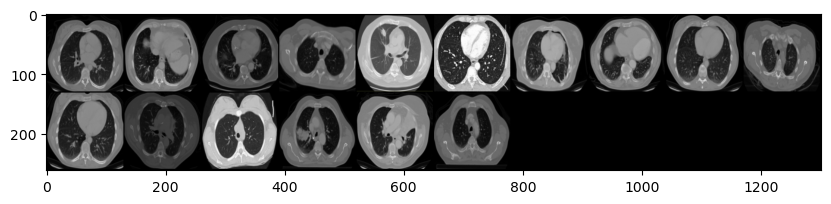

In [31]:
for i in range(16):
    print('Labels: ', class_names[labels[i]],sep = "")

im = make_grid(images[:16],nrow=10)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))
plt.show()

In [32]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # output: (32, 128, 128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # MaxPooling layer (halves the size) output: (32, 64, 64)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # output: (64, 64, 64)
        # MaxPool (32, 32, 32)
        
        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # output: (128, 32, 32)
        # MaxPool (16, 16, 16)
        
        # Fourth convolutional layer
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)  # output: (256, 16, 16)
        # MaxPool (8, 8, 8)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 64, 512)  # First fully connected layer
        self.fc2 = nn.Linear(512, 2) 

    def forward_once(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.mean(dim=1, keepdim=True)
        return x

    def forward(self, x):
        # First branch - CNN features
        output1 = self.forward_once(x)

        # Convert tensor to numpy for LBP feature extraction
        x_numpy = x.cpu().numpy()  # Move to CPU and convert to NumPy
        
        for i in range(10):
            lbp0 = local_binary_pattern(x_numpy[i,0,:,:], 32, 8, 'uniform')
            lbp1 = local_binary_pattern(x_numpy[i,1,:,:], 32, 8, 'uniform')
            lbp2 = local_binary_pattern(x_numpy[i,2,:,:], 32, 8, 'uniform')
            x_numpy[i,0,:,:] = lbp0
            x_numpy[i,1,:,:] = lbp1
            x_numpy[i,2,:,:] = lbp2

        tensor_lbp = torch.from_numpy(x_numpy).float()

        # Second branch - LBP features
        output2 = self.forward_once(tensor_lbp)

        # Combine outputs from both branches
        final_output = output1 + output2

        # Pass the combined output through the remaining layers
        x = final_output.view(final_output.size(0), -1)  # Flatten for fully connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


In [33]:
model = SiameseNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()  # Set model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.4f}")

    print("Training Complete")

In [35]:
train_model(model, train_loader, criterion, optimizer)

C:\Users\Saeed\anaconda3\envs\myenv\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Epoch [1/10], Loss: 0.8284, Accuracy: 0.7468
Epoch [2/10], Loss: 0.6931, Accuracy: 0.7468
Epoch [3/10], Loss: 0.6931, Accuracy: 0.7468
Epoch [4/10], Loss: 0.6931, Accuracy: 0.7468
Epoch [5/10], Loss: 0.6931, Accuracy: 0.7468
Epoch [6/10], Loss: 0.6931, Accuracy: 0.7468
Epoch [7/10], Loss: 0.6931, Accuracy: 0.7468
Epoch [8/10], Loss: 0.6931, Accuracy: 0.7468
Epoch [9/10], Loss: 0.6931, Accuracy: 0.7468
Epoch [10/10], Loss: 0.6931, Accuracy: 0.7468
Training Complete


In [36]:
# Function to evaluate the model
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = correct / total
    return np.array(all_preds), np.array(all_labels), test_acc

# Test the model
preds, true_labels, test_acc = test_model(model, test_loader)

# Print test accuracy
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8286


In [71]:
for images,labels in train_loader:
    break

In [61]:
images.shape

torch.Size([16, 3, 128, 128])

In [62]:
result = model.forward_once(images)

In [63]:
result.shape

torch.Size([16, 1, 64, 64])

In [57]:
result

tensor([[[0.0090, 0.0099, 0.0098,  ..., 0.0097, 0.0097, 0.0087],
         [0.0098, 0.0108, 0.0107,  ..., 0.0106, 0.0105, 0.0088],
         [0.0098, 0.0106, 0.0105,  ..., 0.0104, 0.0103, 0.0087],
         ...,
         [0.0099, 0.0109, 0.0110,  ..., 0.0107, 0.0104, 0.0088],
         [0.0100, 0.0105, 0.0105,  ..., 0.0105, 0.0101, 0.0087],
         [0.0090, 0.0094, 0.0096,  ..., 0.0095, 0.0093, 0.0084]],

        [[0.0089, 0.0098, 0.0096,  ..., 0.0096, 0.0096, 0.0087],
         [0.0097, 0.0106, 0.0105,  ..., 0.0104, 0.0104, 0.0087],
         [0.0096, 0.0104, 0.0103,  ..., 0.0102, 0.0102, 0.0086],
         ...,
         [0.0096, 0.0104, 0.0103,  ..., 0.0102, 0.0102, 0.0087],
         [0.0097, 0.0102, 0.0102,  ..., 0.0102, 0.0101, 0.0087],
         [0.0089, 0.0093, 0.0094,  ..., 0.0093, 0.0093, 0.0083]],

        [[0.0089, 0.0098, 0.0096,  ..., 0.0096, 0.0096, 0.0087],
         [0.0097, 0.0106, 0.0105,  ..., 0.0105, 0.0104, 0.0087],
         [0.0096, 0.0104, 0.0103,  ..., 0.0102, 0.0102, 0.

In [72]:
result2 = model.forward(images)

In [73]:
result2.shape

torch.Size([16, 2])

In [66]:
t = torch.zeros(16,1,64,64)
r = torch.zeros(16,1,64,64)

In [67]:
out = r + t

In [68]:
out.shape

torch.Size([16, 1, 64, 64])